In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/10am_rowdata.csv')
df

,date_only,future_9,future_10,future_2,index_9,index_10,index_2
0,2023-05-18,16026,15971,16070,16060.26,16065.42,16101.88
1,2023-05-19,16153,16120,16129,16146.29,16137.67,16174.92
2,2023-05-22,16133,16120,16116,16168.74,16162.27,16180.89
3,2023-05-23,16149,16105,16133,16186.15,16169.85,16188.03
4,2023-05-24,16055,16071,16072,16186.62,16119.42,16159.32
...,...,...,...,...,...,...,...
121,2023-11-13,16969,16892,16876,16711.53,16877.70,16839.29
122,2023-11-14,16956,16948,16949,16884.52,16921.55,16915.71
123,2023-11-15,17170,17119,17123,17039.62,17109.41,17128.78
124,2023-11-16,17196,17171,17186,17136.52,17120.89,17171.18


In [3]:
# Sort data by date
df = df.sort_values(by='date_only')

# Drop 'date' column for now
df = df.drop(['date_only'], axis=1)
df

,future_9,future_10,future_2,index_9,index_10,index_2
0,16026,15971,16070,16060.26,16065.42,16101.88
1,16153,16120,16129,16146.29,16137.67,16174.92
2,16133,16120,16116,16168.74,16162.27,16180.89
3,16149,16105,16133,16186.15,16169.85,16188.03
4,16055,16071,16072,16186.62,16119.42,16159.32
...,...,...,...,...,...,...
121,16969,16892,16876,16711.53,16877.70,16839.29
122,16956,16948,16949,16884.52,16921.55,16915.71
123,17170,17119,17123,17039.62,17109.41,17128.78
124,17196,17171,17186,17136.52,17120.89,17171.18


In [4]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.        , 0.        , 0.05658972, 0.02427199, 0.02062079,
        0.07543619],
       [0.09243086, 0.10612536, 0.10052122, 0.08844283, 0.07462051,
        0.13020072],
       [0.07787482, 0.10612536, 0.0908414 , 0.10518857, 0.09300657,
        0.13467695],
       [0.08951965, 0.0954416 , 0.10349963, 0.1181749 , 0.09867187,
        0.14003044],
       [0.02110626, 0.07122507, 0.05807893, 0.11852548, 0.06098044,
        0.11850402],
       [0.07714702, 0.12962963, 0.15860015, 0.10161565, 0.16901724,
        0.21798592],
       [0.24454148, 0.3034188 , 0.32836932, 0.35909715, 0.36252681,
        0.37772829],
       [0.42285298, 0.43019943, 0.42889054, 0.43497136, 0.45867994,
        0.47613799],
       [0.38136827, 0.43233618, 0.43335815, 0.4632489 , 0.44660194,
        0.46597086],
       [0.40029112, 0.40527066, 0.36857781, 0.4220447 , 0.39668303,
        0.43314514],
       [0.30131004, 0.33404558, 0.35443038, 0.36048454, 0.34976121,
        0.38342668],
       [0.40101892, 0

In [5]:
# Initialize X and y using the scaled data
X, y = [], []

idx_index_2pm = df.columns.get_loc('index_2')
idx_index_9am = df.columns.get_loc('index_9')
idx_index_10am = df.columns.get_loc('index_10')
idx_future_2pm = df.columns.get_loc('future_2')
idx_future_9am = df.columns.get_loc('future_9')
idx_future_10am = df.columns.get_loc('future_10')


for i in range(1, len(scaled_data)):
    X.append([
        scaled_data[i-2, idx_index_2pm],     # 2 days ago's index 2pm
        scaled_data[i-2, idx_future_2pm],    # 2 days ago's future 2pm
        scaled_data[i-1, idx_index_2pm],     # yesterday's index 2pm
        scaled_data[i-1, idx_future_2pm],    # yesterday's future 2pm
        scaled_data[i, idx_index_9am],       # today's index 9am
        scaled_data[i, idx_future_9am],      # today's future 9am
        scaled_data[i, idx_index_10am],      # today's index 10am
        scaled_data[i, idx_future_10am]      # today's future 10am
    ])
    y.append(scaled_data[i, idx_index_2pm])

X

[[0.9055041950648945,
  0.914370811615786,
  0.07543618927652851,
  0.0565897244973943,
  0.08844283327366043,
  0.092430858806404,
  0.07462050718626045,
  0.10612535612535723],
 [0.07543618927652851,
  0.0565897244973943,
  0.1302007182970808,
  0.10052122114668727,
  0.10518856665473209,
  0.07787481804949081,
  0.09300656965402787,
  0.10612535612535723],
 [0.1302007182970808,
  0.10052122114668727,
  0.134676953760561,
  0.09084139985107953,
  0.11817490153956278,
  0.08951965065502243,
  0.09867186857702315,
  0.0954415954415957],
 [0.134676953760561,
  0.09084139985107953,
  0.14003044140030418,
  0.10349962769918086,
  0.1185254803675857,
  0.02110625909752528,
  0.060980440518099144,
  0.07122507122507216],
 [0.14003044140030418,
  0.10349962769918086,
  0.11850402261361026,
  0.0580789277736411,
  0.10161564625850339,
  0.07714701601164542,
  0.1690172425390699,
  0.12962962962962976],
 [0.11850402261361026,
  0.0580789277736411,
  0.2179859189778881,
  0.15860014892032837,
 

In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Create the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(8, 1)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
4/4 [==============================] - 3s 9ms/step - loss: 0.2040
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0387
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0305
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0134
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 12/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 13/100
4/4 [==============================] - 0s 6ms/st

In [9]:
# Prediction and performance check
predict_index = model.predict(X_test)


1/1 [==============================] - 1s 661ms/step


In [10]:
y_test_array = np.array(y_test)
dummy_array = np.zeros((len(y_test_array), 6))
dummy_array[:, 0] = y_test_array

y_test_inverse_transformed = scaler.inverse_transform(dummy_array)
y_test_origin = y_test_inverse_transformed[:, 0]
y_test_origin

array([17300.23456374, 17224.77175698, 17015.78356614, 16662.5352138 ,
       17050.77976472, 16389.11775423, 16678.56526531, 17231.25177137,
       16492.75677621, 16325.51265268, 16995.45754324, 16730.33326585,
       17089.52592393, 16560.98751603, 17400.        , 16618.11260319,
       16752.95665475, 16686.6524057 , 16760.70382617, 16547.67721619,
       17304.02573273, 16470.72060643, 16204.89578694, 16988.58604944,
       17113.03529253])

In [11]:
predict_array = np.array(predict_index)
dummy_array_predict = np.zeros((len(predict_array), 6))
dummy_array_predict[:, 0] = predict_index.ravel()

predict_inverse_transformed = scaler.inverse_transform(dummy_array_predict)
predict_origin = predict_inverse_transformed[:, 0]
predict_origin

array([17283.20233119, 17200.89606535, 16966.48012197, 16712.83268487,
       16967.40727544, 16414.31068414, 16745.1421119 , 17225.600721  ,
       16599.68552417, 16228.71304393, 17006.93737793, 16730.59355807,
       17050.29435325, 16565.85703468, 17348.37366092, 16574.53993624,
       16687.6542154 , 16800.62267733, 16805.2499274 , 16535.59142375,
       17285.62377334, 16557.46699601, 16178.6855962 , 16922.46494222,
       17160.59998226])

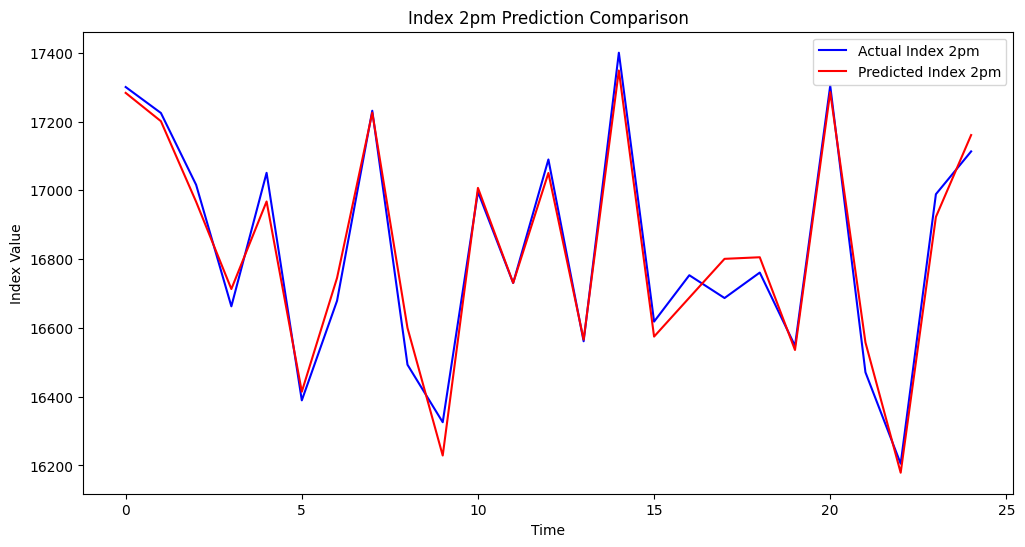

In [12]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_origin, color='blue', label='Actual Index 2pm')
plt.plot(predict_origin, color='red', label='Predicted Index 2pm')
plt.title('Index 2pm Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.show()

In [13]:
model.save("GRU_10am.h5")

c:\Users\overf\anaconda3\envs\StockMarketIndexAI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
